In [9]:
import torch
from d2l import torch as d2l
import numpy as np

d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat', '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'), dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]), batch_size, is_train=True)
    return data_iter, data.shape[1]-1

In [10]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()
        
def train_ch11(trainer_fn, states, hyperparams, data_iter, features_dim, num_epochs=2):
    w = torch.normal(mean=0.0, std=0.01, size=(features_dim, 1), requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X:d2l.linreg(X, w, b), d2l.squared_loss
    
    # train model
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n%200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter), (d2l.evaluate_loss(net, data_iter, loss), ))
                
                timer.start()
    print(f'loss:{animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]
    
          

loss:0.258, 0.034 sec/epoch


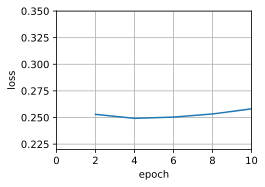

In [11]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr':lr}, data_iter, feature_dim, num_epochs
    )
    
gd_res = train_sgd(1, 1500, 10)

loss:0.244, 0.044 sec/epoch


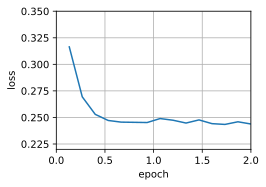

In [12]:
sgd_res = train_sgd(0.005, 1)

loss:0.245, 0.002 sec/epoch


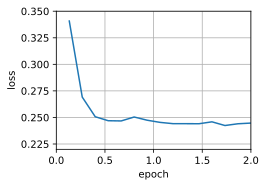

In [13]:
mini1_res = train_sgd(.4, 100)

loss:0.244, 0.007 sec/epoch


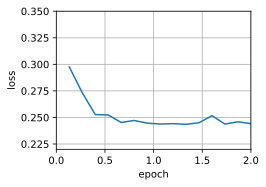

In [14]:
mini2_res = train_sgd(.05, 10)

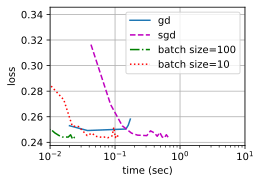

In [15]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')